# Predykcja współczynnika CTR na podstawie danych AVAZU

11days of online advertising data 


Data fields

    id: ad identifier
    click: 0/1 for non-click/click
    hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
    C1 -- anonymized categorical variable
    banner_pos
    site_id
    site_domain
    site_category
    app_id
    app_domain
    app_category
    device_id
    device_ip
    device_model
    device_type
    device_conn_type
    C14-C21 -- anonymized categorical variables


## 1. Makes sure we have required packages

In [1]:
%%bash
# pip install --user pandas
# pip install --user seaborn
pip install --user nbconvert

## 2. Import data

In [2]:
import pandas as pd
import numpy as np

import gzip
import random

from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

DATA_PATH = 'avazu-ctr-prediction/learn.csv'
DATA_TYPES = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21': np.dtype(int)
}


In [3]:
TOTAL_RECORDS = 40428967
SAMPLE_SIZE = 1000000

ROWS_TO_SKIP = sorted(random.sample(range(1, TOTAL_RECORDS), TOTAL_RECORDS - SAMPLE_SIZE))

In [4]:
DATE_TIME_FORMAT = '%y%m%d%H' # Date is in UTC TZ
DATE_COLUMNS = ['hour']
DATE_PARSER = lambda raw_date: datetime.strptime(raw_date, DATE_TIME_FORMAT)

raw_data = pd.read_csv(DATA_PATH,
                       dtype=DATA_TYPES,
                       parse_dates=DATE_COLUMNS,
                       date_parser=DATE_PARSER,
                       skiprows=ROWS_TO_SKIP)

In [39]:
raw_data.head().iloc[:, 0:10]

id  click       date    C1  banner_pos   site_id  \
0  10005249248600843539      0 2014-10-21  1005           0  1fbe01fe   
1  10019174283089529533      0 2014-10-21  1005           0  bb4524e7   
2  10021850042230398994      0 2014-10-21  1005           0  1fbe01fe   
3  10024810769855576624      1 2014-10-21  1002           0  84c7ba46   
4  10025422497693324685      0 2014-10-21  1005           0  1fbe01fe   

  site_domain site_category    app_id app_domain  
0    f3845767      28905ebd  ecad2386   7801e8d9  
1    d733bbc3      28905ebd  ecad2386   7801e8d9  
2    f3845767      28905ebd  ecad2386   7801e8d9  
3    c4e18dd6      50e219e0  ecad2386   7801e8d9  
4    f3845767      28905ebd  ecad2386   7801e8d9

In [40]:
raw_data.head().iloc[:, 10:]

app_category device_id device_ip device_model  device_type  \
0     07d7df22  a99f214a  e99d0c2e     d25693ce            1   
1     07d7df22  a99f214a  60f59ef9     ab145aa1            1   
2     07d7df22  a99f214a  d3c7f33f     5096d134            1   
3     07d7df22  df373817  73d211e5     cf19f7f7            0   
4     07d7df22  a99f214a  e54c1344     06fbfd42            1   

   device_conn_type    C14  C15  C16   C17  C18  C19     C20  C21  
0                 0  15706  320   50  1722    0   35  100083   79  
1                 0   9438  320   50   898    3  427  100003   61  
2                 0  15702  320   50  1722    0   35      -1   79  
3                 0  21660  320   50  2446    3  171  100228  156  
4                 0  15706  320   50  1722    0   35      -1   79

In [5]:
raw_data = raw_data.rename(columns={'hour': 'date'})
raw_data['hour_by_day'] = raw_data.date.apply(lambda d: d.hour)
raw_data['day_by_week'] = raw_data.date.apply(lambda d: d.day_name())

raw_data.id.value_counts()

6217732817933507892     1
16865624470765969718    1
4024481103668516134     1
18120436888476570726    1
5233127955582156837     1
                       ..
1492157876266651751     1
13295907764497083515    1
15068124693110198116    1
4281030513198797855     1
9591934022406372312     1
Name: id, Length: 1000000, dtype: int64

## 3. Parse and analize avazu data 

Lest's see CTR of our data

In [2]:
# ctr = raw_data['click'].value_counts()/len(raw_data)
# sns.barplot(x='CTR', data={'CTR': ctr[1]}, palette='hls', orient='v')
# # plt.ylim((0,.5))
# plt.xlabel('CTR')
# plt.ylabel('CTR Persentage')
# plt.show()

raw_data.id

NameError: name 'raw_data' is not defined

#### Lets group data by hour

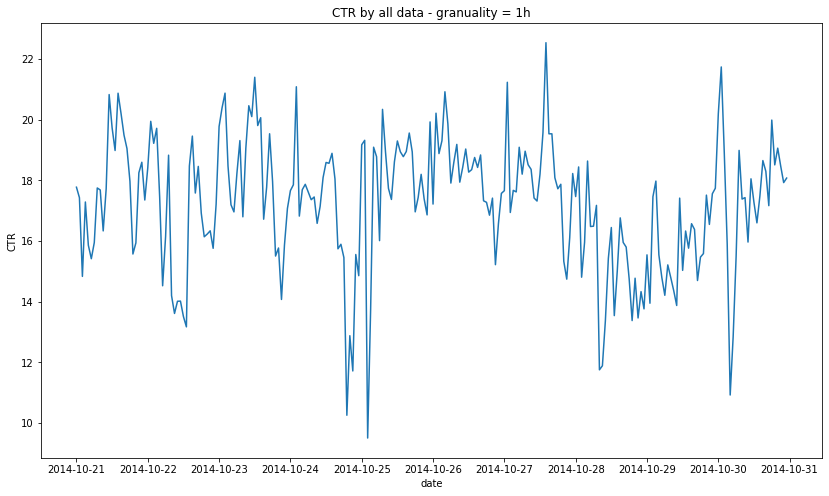

In [10]:
granuality_hour = raw_data.resample('H', on='date').agg({
                              'click': [('clicks', 'sum'), ('impressions', 'count')]
                          })
granuality_hour.columns = granuality_hour.columns.get_level_values(1)
granuality_hour['CTR'] = granuality_hour['clicks']/granuality_hour['impressions'] * 100
granuality_hour = granuality_hour.reset_index()

plt.figure(figsize=(14,8))
sns.lineplot(y='CTR', x='date', data=granuality_hour)
plt.title('CTR by all data - granuality = 1h');
plt.show()

### 3.1 Clicks distribution in a hour

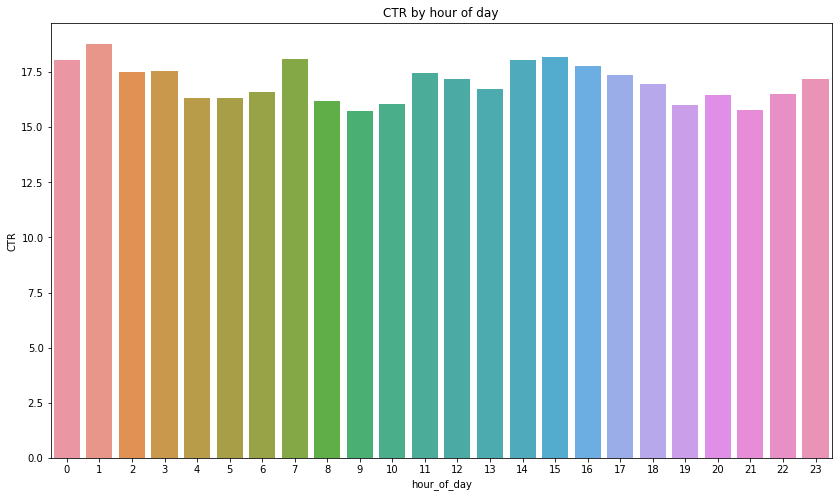

In [23]:
hour_by_day = raw_data.resample('H', on='date').agg({
                              'click': [('clicks', 'sum'), ('impressions', 'count')]
                          })
hour_by_day.columns = hour_by_day.columns.get_level_values(1)
hour_by_day = hour_by_day.reset_index()

hour_by_day['hour_of_day'] = hour_by_day.date.apply(lambda d: d.hour)
hour_by_day = hour_by_day.groupby('hour_of_day').sum()
hour_by_day['CTR'] = hour_by_day['clicks']/hour_by_day['impressions'] * 100
hour_by_day = hour_by_day.reset_index()

hour_by_day = hour_by_day[hour_by_day['impressions'] > 10000]

# hour_by_day.CTR = (hour_by_day.CTR - hour_by_day.CTR.mean())/hour_by_day.CTR.std()

plt.figure(figsize=(14,8))
sns.barplot(y='CTR', x='hour_of_day', data=hour_by_day)
plt.title('CTR by hour of day');
plt.show()

### 3.2 Clicks distribution in a day

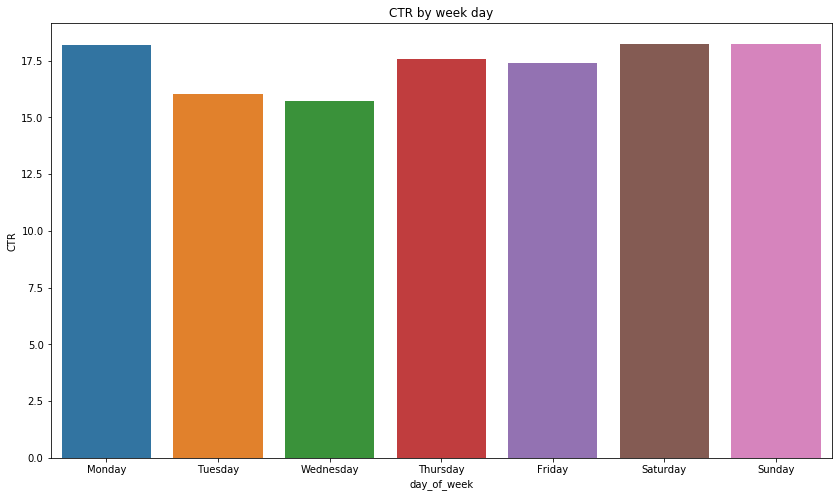

In [9]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_by_week = raw_data.resample('D', on='date').agg({
                              'click': [('clicks', 'sum'), ('impressions', 'count')]
                          })
day_by_week.columns = day_by_week.columns.get_level_values(1)
day_by_week = day_by_week.reset_index()

day_by_week['day_of_week'] = day_by_week.date.apply(lambda d: d.day_name())
day_by_week = day_by_week.groupby('day_of_week').sum().reindex(cats)
day_by_week['CTR'] = day_by_week['clicks']/day_by_week['impressions'] * 100
day_by_week = day_by_week.reset_index()

plt.figure(figsize=(14,8))
sns.barplot(y='CTR', x='day_of_week', data=day_by_week, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('CTR by week day');
plt.show()

### 3.2 Anonymized CX attributes 

C1, C14-C20 attributes are anonimized atributes - we can see that Pearson's correlation coefficient beetween C14/C17



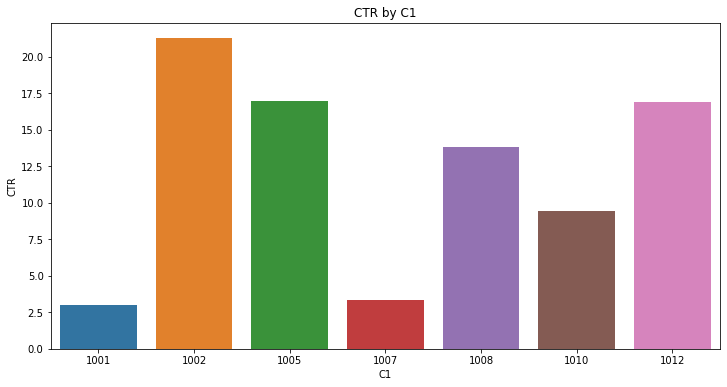

In [58]:
C1_ctr_cor = raw_data[['C1', 'click']].groupby(['C1']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C1_ctr_cor.columns = C1_ctr_cor.columns.get_level_values(1)
C1_ctr_cor = C1_ctr_cor.reset_index()

C1_ctr_cor['CTR'] = C1_ctr_cor['clicks']/C1_ctr_cor['impressions'] * 100

# len(C1_ctr_cor.C1.value_counts())

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=C1_ctr_cor)
plt.title('CTR by C1');

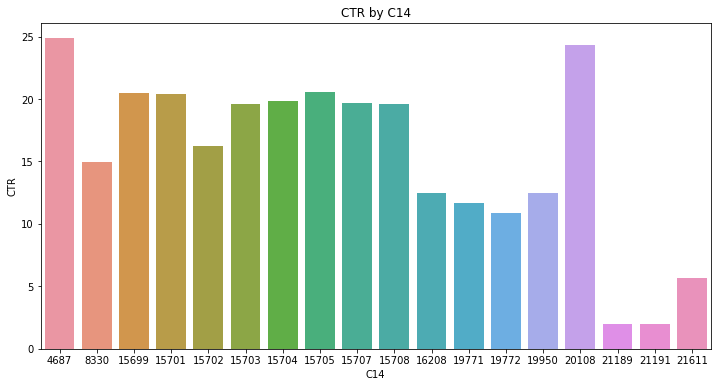

In [57]:
C14_ctr_cor = raw_data[['C14', 'click']].groupby(['C14']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C14_ctr_cor.columns = C14_ctr_cor.columns.get_level_values(1)
C14_ctr_cor = C14_ctr_cor.reset_index()
C14_ctr_cor['CTR'] = C14_ctr_cor['clicks']/C14_ctr_cor['impressions'] * 100

C14_ctr_cor_top = C14_ctr_cor[C14_ctr_cor['impressions'] > 12000].sort_values(by=['C14'])

# len(C14_ctr_cor.C14.value_counts())

plt.figure(figsize=(12,6))
sns.barplot(x='C14', y='CTR', data=C14_ctr_cor_top)
plt.title('CTR by C14')
plt.show()

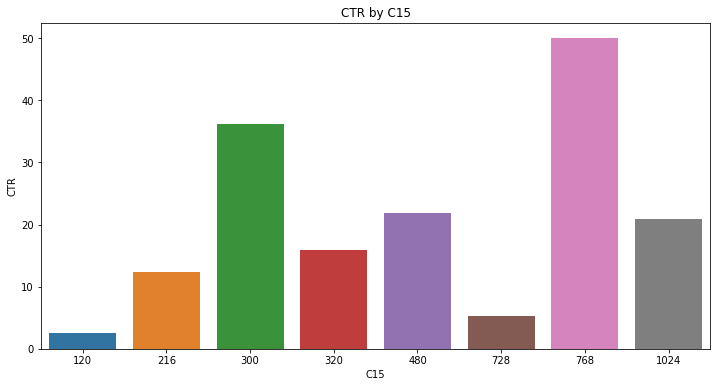

In [56]:
C15_ctr_cor = raw_data[['C15', 'click']].groupby(['C15']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C15_ctr_cor.columns = C15_ctr_cor.columns.get_level_values(1)
C15_ctr_cor = C15_ctr_cor.reset_index()
C15_ctr_cor['CTR'] = C15_ctr_cor['clicks']/C15_ctr_cor['impressions'] * 100

# len(C15_ctr_cor.C15.value_counts())

plt.figure(figsize=(12,6))
sns.barplot(x='C15', y='CTR', data=C15_ctr_cor)
plt.title('CTR by C15')
plt.show()

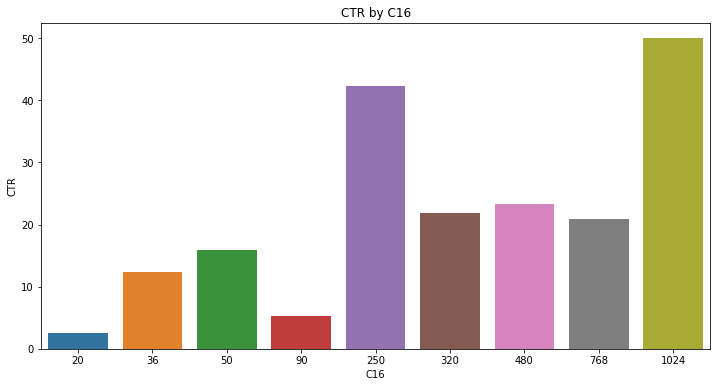

In [55]:
C16_ctr_cor = raw_data[['C16', 'click']].groupby(['C16']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C16_ctr_cor.columns = C16_ctr_cor.columns.get_level_values(1)
C16_ctr_cor = C16_ctr_cor.reset_index()
C16_ctr_cor['CTR'] = C16_ctr_cor['clicks']/C16_ctr_cor['impressions'] * 100

# len(C16_ctr_cor.C16.value_counts())

plt.figure(figsize=(12,6))
sns.barplot(x='C16', y='CTR', data=C16_ctr_cor)
plt.title('CTR by C16')
plt.show()

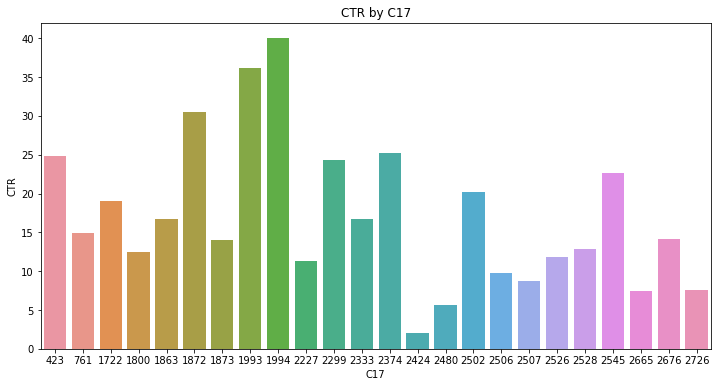

In [54]:
C17_ctr_cor = raw_data[['C17', 'click']].groupby(['C17']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C17_ctr_cor.columns = C17_ctr_cor.columns.get_level_values(1)
C17_ctr_cor = C17_ctr_cor.reset_index()
C17_ctr_cor['CTR'] = C17_ctr_cor['clicks']/C17_ctr_cor['impressions'] * 100

C17_ctr_cor_top = C17_ctr_cor[C17_ctr_cor['impressions'] > 10000].sort_values(by=['C17'])

# len(C17_ctr_cor.C17.value_counts())

plt.figure(figsize=(12,6))
sns.barplot(x='C17', y='CTR', data=C17_ctr_cor_top)
plt.title('CTR by C17')
plt.show()

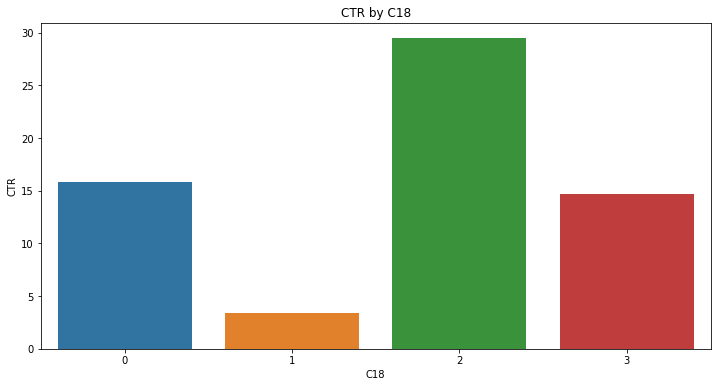

In [53]:
C18_ctr_cor = raw_data[['C18', 'click']].groupby(['C18']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C18_ctr_cor.columns = C18_ctr_cor.columns.get_level_values(1)
C18_ctr_cor = C18_ctr_cor.reset_index()
C18_ctr_cor['CTR'] = C18_ctr_cor['clicks']/C18_ctr_cor['impressions'] * 100

# len(C18_ctr_cor.C18.value_counts())


plt.figure(figsize=(12,6))
sns.barplot(x='C18', y='CTR', data=C18_ctr_cor)
plt.title('CTR by C18')
plt.show()

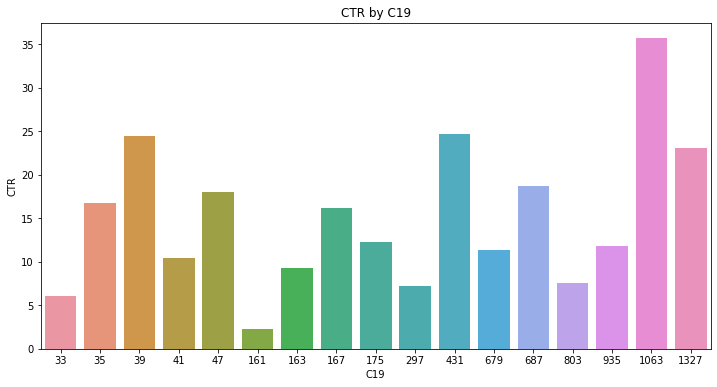

In [51]:
C19_ctr_cor = raw_data[['C19', 'click']].groupby(['C19']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C19_ctr_cor.columns = C19_ctr_cor.columns.get_level_values(1)
C19_ctr_cor = C19_ctr_cor.reset_index()
C19_ctr_cor['CTR'] = C19_ctr_cor['clicks']/C19_ctr_cor['impressions'] * 100
C19_ctr_cor_top = C19_ctr_cor[C19_ctr_cor['impressions'] > 10000].sort_values(by=['C19'])

# len(C19_ctr_cor.C19.value_counts())


plt.figure(figsize=(12,6))
sns.barplot(x='C19', y='CTR', data=C19_ctr_cor_top)
plt.title('CTR by C19')
plt.show()

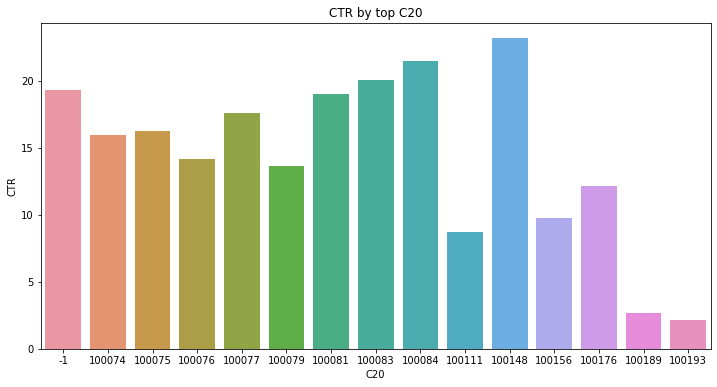

In [49]:
C20_ctr_cor = raw_data[['C20', 'click']].groupby(['C20']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C20_ctr_cor.columns = C20_ctr_cor.columns.get_level_values(1)
C20_ctr_cor = C20_ctr_cor.reset_index()
C20_ctr_cor['CTR'] = C20_ctr_cor['clicks']/C20_ctr_cor['impressions'] * 100
C20_ctr_cor_top = C20_ctr_cor[C20_ctr_cor['impressions'] > 10000].sort_values(by=['C20'])

# len(C20_ctr_cor.C20.value_counts())

plt.figure(figsize=(12,6))
sns.barplot(x='C20', y='CTR', data=C20_ctr_cor_top)
plt.title('CTR by top C20')
plt.show()

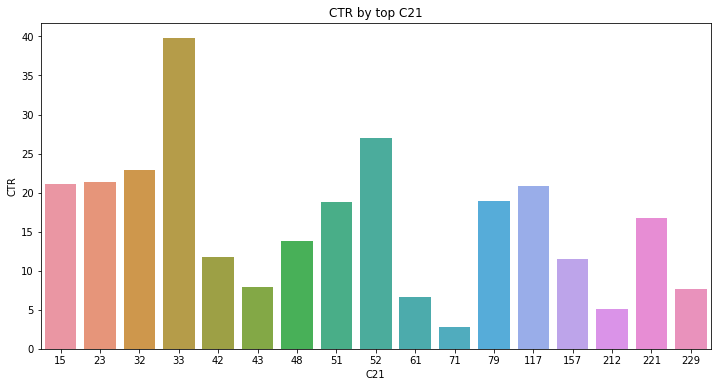

In [59]:
C21_ctr_cor = raw_data[['C21', 'click']].groupby(['C21']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
C21_ctr_cor.columns = C21_ctr_cor.columns.get_level_values(1)
C21_ctr_cor = C21_ctr_cor.reset_index()
C21_ctr_cor['CTR'] = C21_ctr_cor['clicks']/C21_ctr_cor['impressions'] * 100
C21_ctr_cor_top = C21_ctr_cor[C21_ctr_cor['impressions'] > 10000].sort_values(by=['C21'])

# len(C21_ctr_cor.C21.value_counts())

plt.figure(figsize=(12,6))
sns.barplot(x='C21', y='CTR', data=C21_ctr_cor_top)
plt.title('CTR by top C21')
plt.show()

### 3.3 Site attributes

site_id
site_domain
site_category

    SITE ID

Unique site ids: 2674



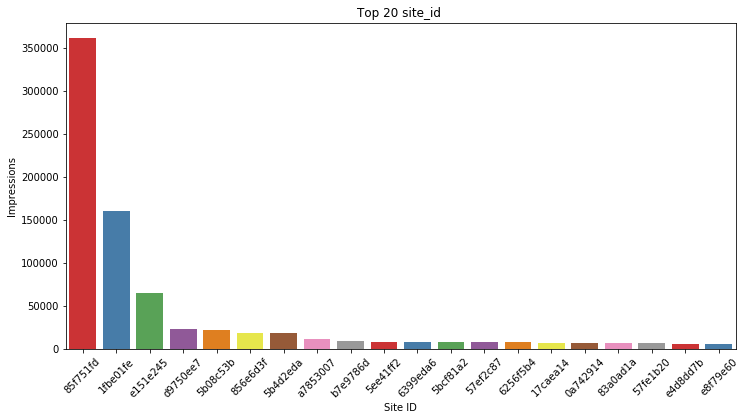

In [60]:
UNIQUE_IDS = raw_data.site_id.nunique()
print(f'Unique site ids: {UNIQUE_IDS}')
print()

data=raw_data.site_id.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[:20], x='index', y='site_id',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Top 20 site_id ')
plt.xlabel('Site ID')
plt.ylabel('Impressions')
plt.show()

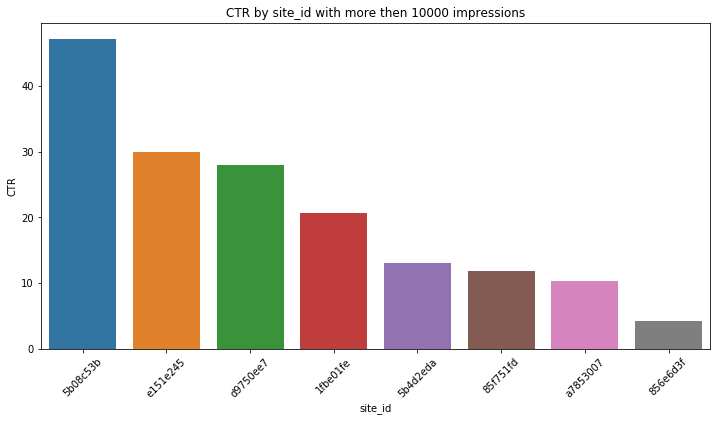

In [62]:
site_id_ctr_cor = raw_data[['site_id', 'click']].groupby(['site_id']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
site_id_ctr_cor.columns = site_id_ctr_cor.columns.get_level_values(1)
site_id_ctr_cor = site_id_ctr_cor.reset_index()
site_id_ctr_cor['CTR'] = site_id_ctr_cor['clicks']/site_id_ctr_cor['impressions'] * 100
site_id_ctr_cor_top = site_id_ctr_cor[site_id_ctr_cor['impressions'] > 10000]

plt.figure(figsize=(12,6))
chart = sns.barplot(x='site_id', y='CTR', data=site_id_ctr_cor_top, order=site_id_ctr_cor_top.sort_values(by='CTR', ascending=False).site_id)
plt.title('CTR by site_id with more then 10000 impressions')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()


    SITE DOMAINS

Unique site domains: 2844



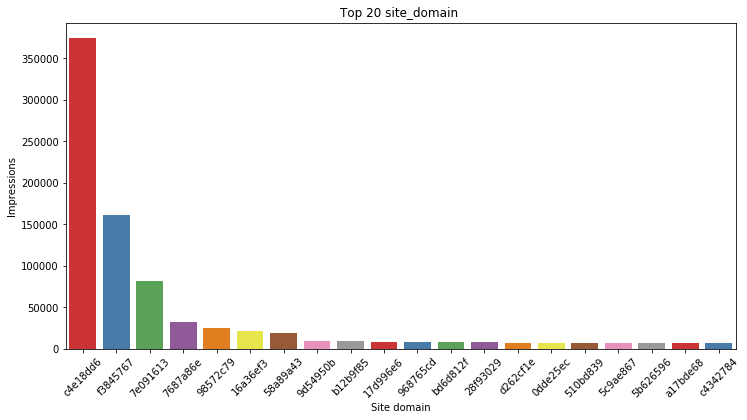

In [64]:
UNIQUE_DOMAINS = raw_data.site_domain.nunique()
print(f'Unique site domains: {UNIQUE_DOMAINS}')
print()

data=raw_data.site_domain.value_counts().reset_index()
plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[:20], x='index', y='site_domain',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Top 20 site_domain ')
plt.xlabel('Site domain')
plt.ylabel('Impressions')
plt.show()

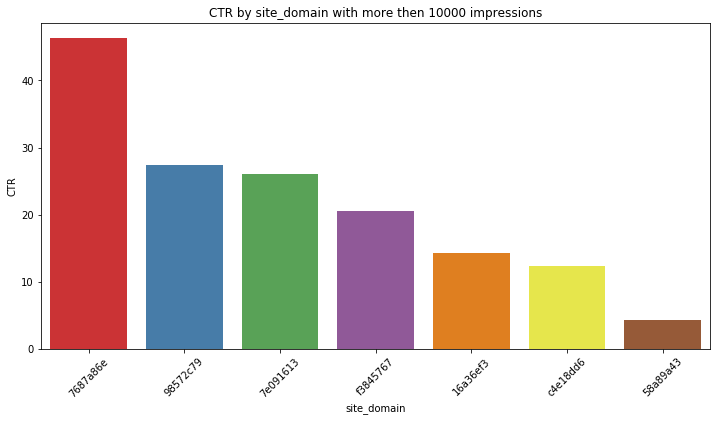

In [63]:
site_domian_ctr_cor = raw_data[['site_domain', 'click']].groupby(['site_domain']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
site_domian_ctr_cor.columns = site_domian_ctr_cor.columns.get_level_values(1)
site_domian_ctr_cor = site_domian_ctr_cor.reset_index()
site_domian_ctr_cor['CTR'] = site_domian_ctr_cor['clicks']/site_domian_ctr_cor['impressions'] * 100
site_domian_ctr_cor_top = site_domian_ctr_cor[site_domian_ctr_cor['impressions'] > 10000]

plt.figure(figsize=(12,6))
chart = sns.barplot(data=site_domian_ctr_cor_top, 
                    x='site_domain', 
                    y='CTR',
                    palette='Set1',
                    order=site_domian_ctr_cor_top.sort_values(by='CTR', ascending=False).site_domain)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by site_domain with more then 10000 impressions')
plt.show()

    SITE CATEGORY

Unique site category: 22



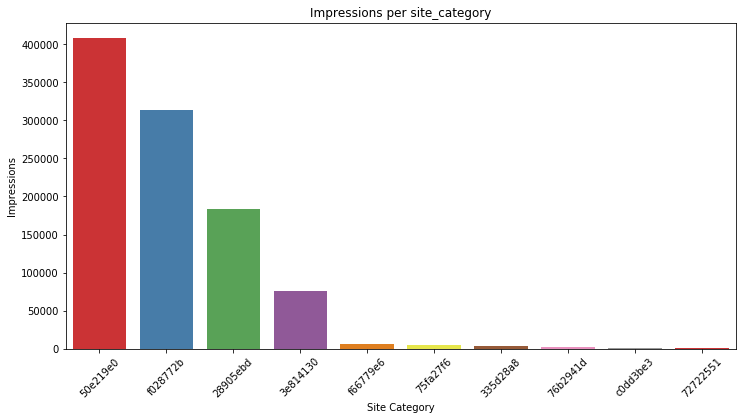

In [22]:
UNIQUE_CAT = raw_data.site_category.nunique()
print(f'Unique site category: {UNIQUE_CAT}')
print()

data = raw_data.site_category.value_counts().reset_index()
plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[:10], x='index', y='site_category',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per site_category')
plt.xlabel('Site Category')
plt.ylabel('Impressions')
plt.show()

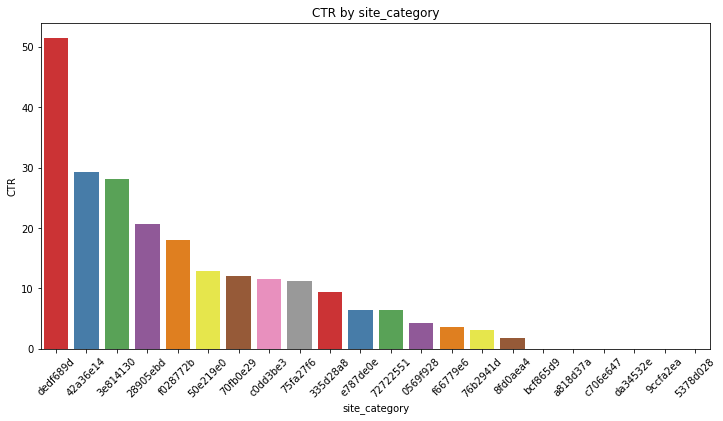

In [23]:
site_category_ctr_cor = raw_data[['site_category', 'click']].groupby(['site_category']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
site_category_ctr_cor.columns = site_category_ctr_cor.columns.get_level_values(1)
site_category_ctr_cor = site_category_ctr_cor.reset_index()
site_category_ctr_cor['CTR'] = site_category_ctr_cor['clicks']/site_category_ctr_cor['impressions'] * 100

plt.figure(figsize=(12,6))
chart = sns.barplot(data=site_category_ctr_cor, 
                    x='site_category', 
                    y='CTR',
                    palette='Set1',
                    order=site_category_ctr_cor.sort_values(by='CTR', ascending=False).site_category)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by site_category')
plt.show()

### 3.4 App attributes
   app_id
   app_domain
   app_category

    APP ID

Unique app ids: 3111



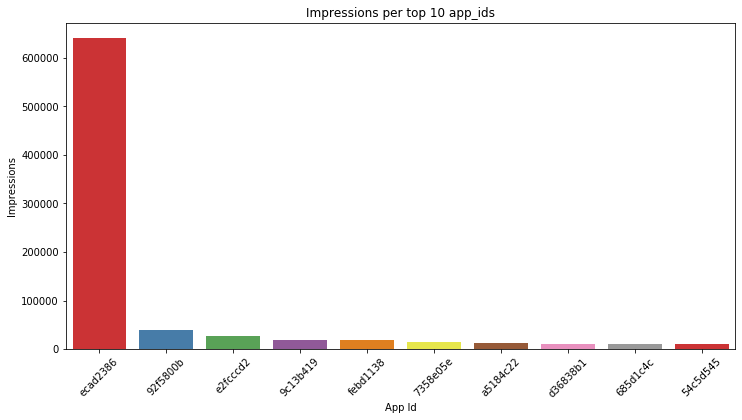

In [24]:
UNIQUE_APP_ID = raw_data.app_id.nunique()
print(f'Unique app ids: {UNIQUE_APP_ID}')
print()

data = raw_data.app_id.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[:10], x='index', y='app_id',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per top 10 app_ids')
plt.xlabel('App Id')
plt.ylabel('Impressions')
plt.show()

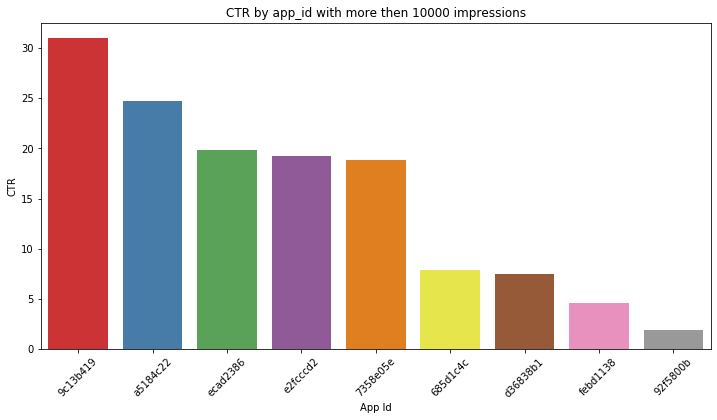

In [67]:
app_id_ctr_cor = raw_data[['app_id', 'click']].groupby(['app_id']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
app_id_ctr_cor.columns = app_id_ctr_cor.columns.get_level_values(1)
app_id_ctr_cor = app_id_ctr_cor.reset_index()
app_id_ctr_cor['CTR'] = app_id_ctr_cor['clicks']/app_id_ctr_cor['impressions'] * 100
app_id_ctr_cor_top = app_id_ctr_cor[app_id_ctr_cor['impressions'] > 10000]

plt.figure(figsize=(12,6))
chart = sns.barplot(data=app_id_ctr_cor_top, 
                    x='app_id', 
                    y='CTR',
                    palette='Set1',
                    order=app_id_ctr_cor_top.sort_values(by='CTR', ascending=False).app_id)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by app_id with more then 10000 impressions')
plt.xlabel('App Id')

plt.show()

    APP DOMAIN

Unique app domains: 200



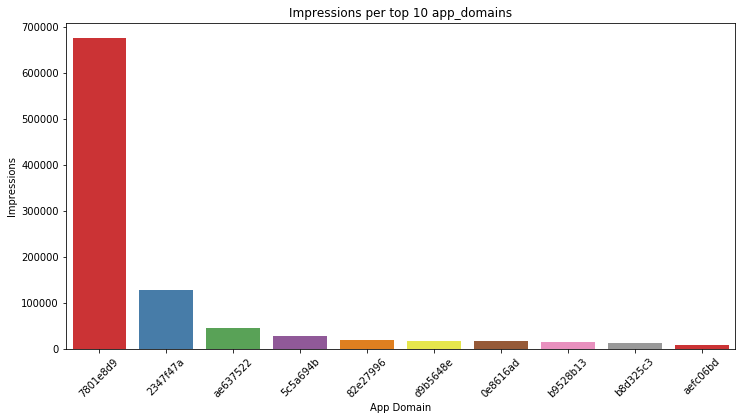

In [26]:
UNIQUE_APP_DOMAINS = raw_data.app_domain.nunique()
print(f'Unique app domains: {UNIQUE_APP_DOMAINS}')
print()

data = raw_data.app_domain.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[:10], x='index', y='app_domain',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per top 10 app_domains')
plt.xlabel('App Domain')
plt.ylabel('Impressions')
plt.show()

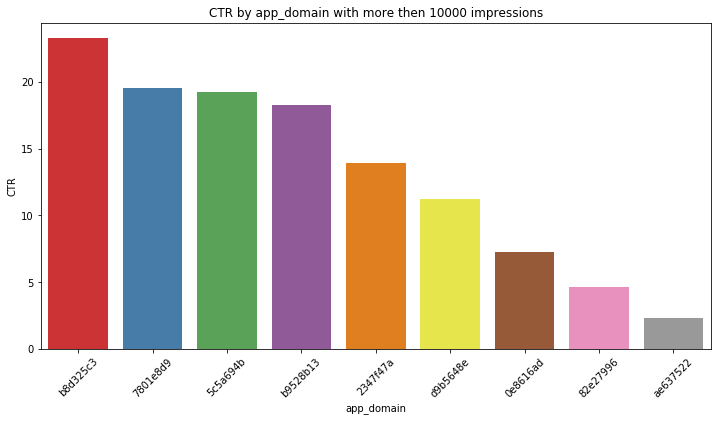

In [69]:
app_domain_ctr_cor = raw_data[['app_domain', 'click']].groupby(['app_domain']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
app_domain_ctr_cor.columns = app_domain_ctr_cor.columns.get_level_values(1)
app_domain_ctr_cor = app_domain_ctr_cor.reset_index()
app_domain_ctr_cor['CTR'] = app_domain_ctr_cor['clicks']/app_domain_ctr_cor['impressions'] * 100
app_domain_ctr_cor = app_domain_ctr_cor[app_domain_ctr_cor['impressions'] > 10000]

plt.figure(figsize=(12,6))
chart = sns.barplot(data=app_domain_ctr_cor, 
                    x='app_domain', 
                    y='CTR',
                    palette='Set1',
                    order=app_domain_ctr_cor.sort_values(by='CTR', ascending=False).app_domain)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by app_domain with more then 10000 impressions')
plt.show()

    APP CATEGORY

Unique app categories: 26



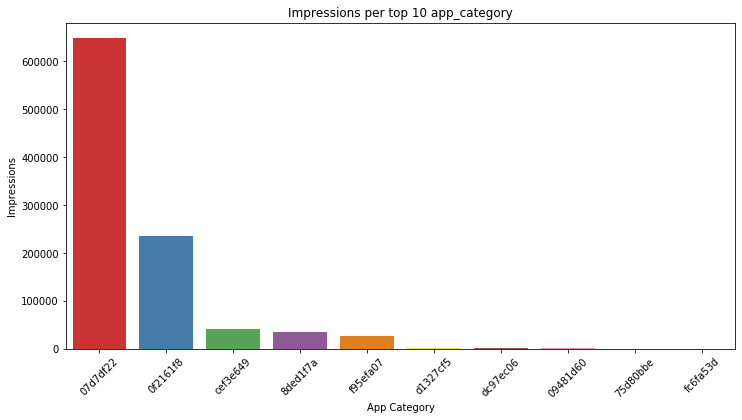

In [28]:
UNIQUE_APP_CAT = raw_data.app_category.nunique()
print(f'Unique app categories: {UNIQUE_APP_CAT}')
print()

data = raw_data.app_category.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[:10], x='index', y='app_category',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per top 10 app_category')
plt.xlabel('App Category')
plt.ylabel('Impressions')
plt.show()

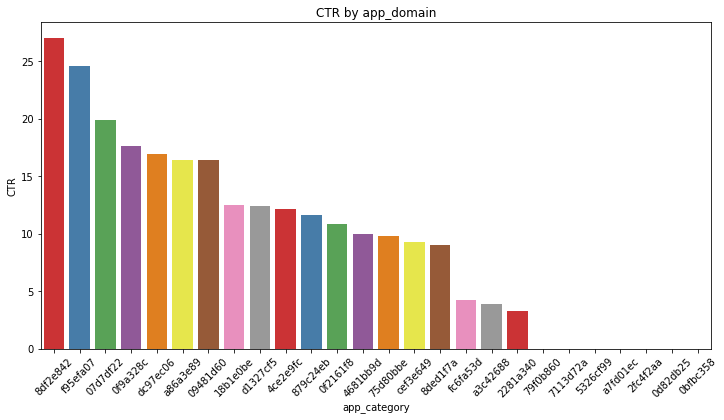

In [29]:
app_cat_ctr_cor = raw_data[['app_category', 'click']].groupby(['app_category']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
app_cat_ctr_cor.columns = app_cat_ctr_cor.columns.get_level_values(1)
app_cat_ctr_cor = app_cat_ctr_cor.reset_index()
app_cat_ctr_cor['CTR'] = app_cat_ctr_cor['clicks']/app_cat_ctr_cor['impressions'] * 100

plt.figure(figsize=(12,6))
chart = sns.barplot(data=app_cat_ctr_cor, 
                    x='app_category',
                    y='CTR',
                    palette='Set1',
                    order=app_cat_ctr_cor.sort_values(by='CTR', ascending=False).app_category)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by app_domain')
plt.show()

### 3.5 Device attributes

device_id
device_ip
device_model
device_type
device_conn_type

    DEVICE ID
    
    Probably device id = a99f214a is UNKNOW_DEVICE

Unique device ids: 150226



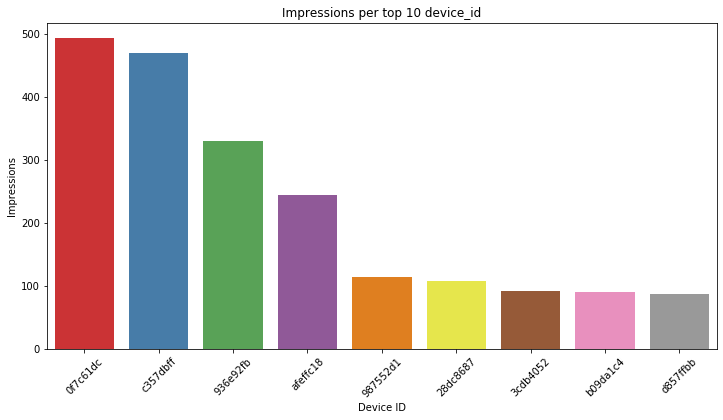

In [30]:
UNIQUE_DEVICE_ID = raw_data.device_id.nunique()
print(f'Unique device ids: {UNIQUE_DEVICE_ID}')
print()

data = raw_data.device_id.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[1:10], x='index', y='device_id', palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per top 10 device_id')
plt.xlabel('Device ID')
plt.ylabel('Impressions')
plt.show()

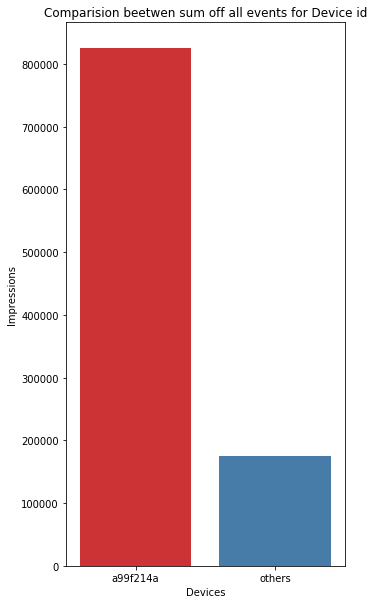

In [70]:
data = raw_data.device_id.value_counts().reset_index()

plt.figure(figsize=(5,10))
comp = pd.DataFrame.from_dict({
    'a99f214a': [data[0:1].device_id.sum()],
    'others': [data[1:].device_id.sum()]
})
chart = sns.barplot(data=comp, palette='Set1')
plt.title('Comparision beetwen sum off all events for Device id')
plt.xlabel('Devices')
plt.ylabel('Impressions')
plt.show()

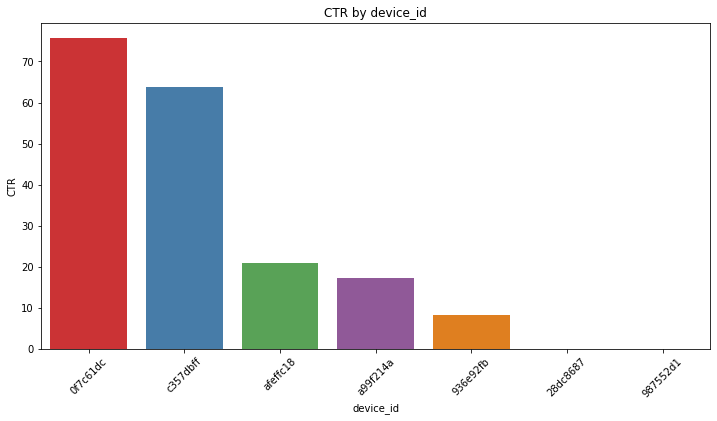

In [32]:
device_id_ctr_cor = raw_data[['device_id', 'click']].groupby(['device_id']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
device_id_ctr_cor.columns = device_id_ctr_cor.columns.get_level_values(1)
device_id_ctr_cor = device_id_ctr_cor.reset_index()
device_id_ctr_cor['CTR'] = device_id_ctr_cor['clicks']/device_id_ctr_cor['impressions'] * 100
device_id_ctr_cor = device_id_ctr_cor[device_id_ctr_cor['impressions'] > 100]

plt.figure(figsize=(12,6))
chart = sns.barplot(data=device_id_ctr_cor, 
                    x='device_id',
                    y='CTR',
                    palette='Set1',
                    order=device_id_ctr_cor.sort_values(by='CTR', ascending=False).device_id)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by device_id')
plt.show()

    DEVICE IP

Unique device ip: 555305



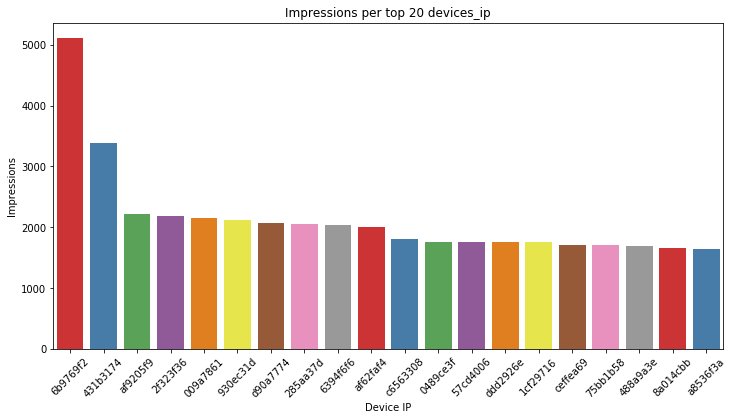

In [71]:
UNIQUE_DEVICE_IP = raw_data.device_ip.nunique()
print(f'Unique device ip: {UNIQUE_DEVICE_IP}')
print()

data = raw_data.device_ip.value_counts().reset_index()
plt.figure(figsize=(12,6))
data[:1000]
chart = sns.barplot(data=data[:20], x='index', y='device_ip',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per top 20 devices_ip')
plt.xlabel('Device IP')
plt.ylabel('Impressions')
plt.show()


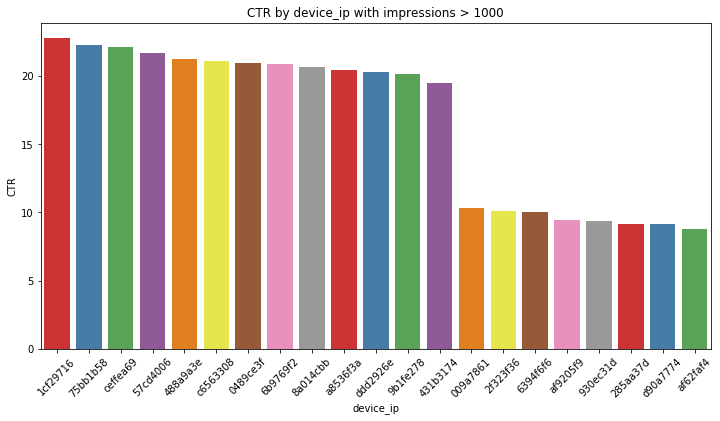

In [73]:
device_ip_ctr_cor = raw_data[['device_ip', 'click']].groupby(['device_ip']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
device_ip_ctr_cor.columns = device_ip_ctr_cor.columns.get_level_values(1)
device_ip_ctr_cor = device_ip_ctr_cor.reset_index()
device_ip_ctr_cor['CTR'] = device_ip_ctr_cor['clicks']/device_ip_ctr_cor['impressions'] * 100
device_ip_ctr_cor = device_ip_ctr_cor[device_ip_ctr_cor['impressions'] > 1000]

plt.figure(figsize=(12,6))
chart = sns.barplot(data=device_ip_ctr_cor, 
                    x='device_ip',
                    y='CTR',
                    palette='Set1',
                    order=device_ip_ctr_cor.sort_values(by='CTR', ascending=False).device_ip)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by device_ip with impressions > 1000')
plt.show()



    DEVICE MODEL

Unique device models: 5171



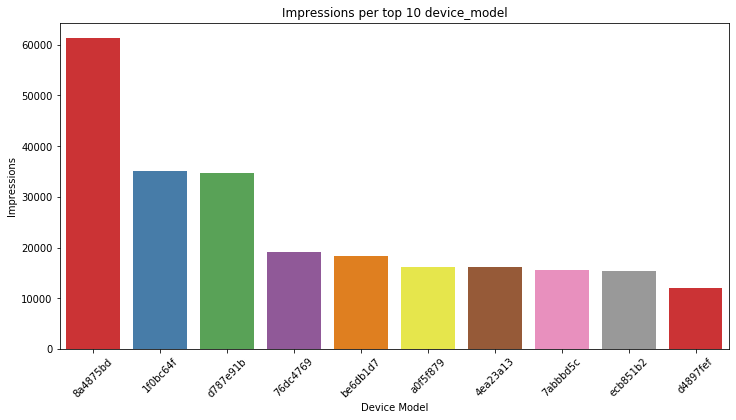

In [35]:
UNIQUE_DEVICE_MODEL = raw_data.device_model.nunique()
print(f'Unique device models: {UNIQUE_DEVICE_MODEL}')
print()

data = raw_data.device_model.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data[:10], x='index', y='device_model',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per top 10 device_model')
plt.xlabel('Device Model')
plt.ylabel('Impressions')
plt.show()

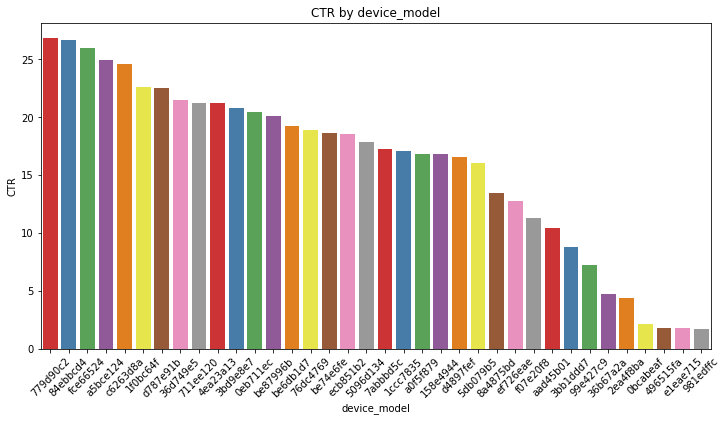

In [36]:
dev_model_ctr_cor = raw_data[['device_model', 'click']].groupby(['device_model']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
dev_model_ctr_cor.columns = dev_model_ctr_cor.columns.get_level_values(1)
dev_model_ctr_cor = dev_model_ctr_cor.reset_index()
dev_model_ctr_cor['CTR'] = dev_model_ctr_cor['clicks']/dev_model_ctr_cor['impressions'] * 100
dev_model_ctr_cor = dev_model_ctr_cor[dev_model_ctr_cor['impressions'] > 5000]

plt.figure(figsize=(12,6))
chart = sns.barplot(data=dev_model_ctr_cor, 
                    x='device_model',
                    y='CTR',
                    palette='Set1',
                    order=dev_model_ctr_cor.sort_values(by='CTR', ascending=False).device_model)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by device_model')
plt.show()

    DEVICE TYPE

Unique device types: 5



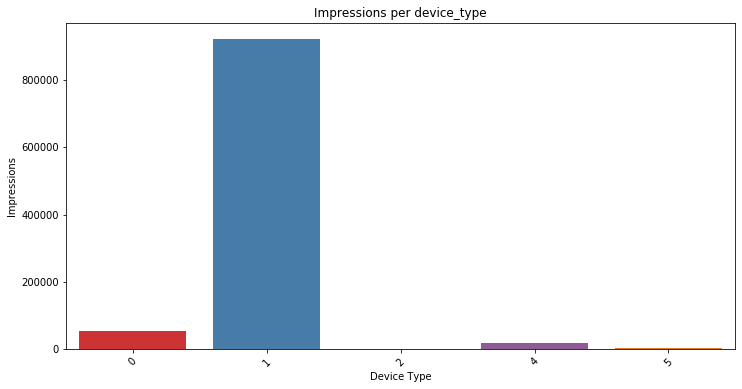

In [37]:
UNIQUE_DEVICE_TYPES = raw_data.device_type.nunique()
print(f'Unique device types: {UNIQUE_DEVICE_TYPES}')
print()

data = raw_data.device_type.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data, x='index', y='device_type',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per device_type')
plt.xlabel('Device Type')
plt.ylabel('Impressions')
plt.show()

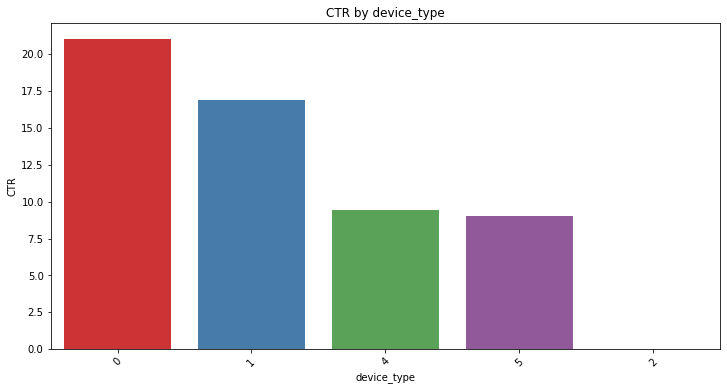

In [38]:
dev_type_ctr_cor = raw_data[['device_type', 'click']].groupby(['device_type']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
dev_type_ctr_cor.columns = dev_type_ctr_cor.columns.get_level_values(1)
dev_type_ctr_cor = dev_type_ctr_cor.reset_index()
dev_type_ctr_cor['CTR'] = dev_type_ctr_cor['clicks']/dev_type_ctr_cor['impressions'] * 100

plt.figure(figsize=(12,6))
chart = sns.barplot(data=dev_type_ctr_cor, 
                    x='device_type',
                    y='CTR',
                    palette='Set1',
                    order=dev_type_ctr_cor.sort_values(by='CTR', ascending=False).device_type)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by device_type')
plt.show()

    DEVICE CONNECTION TYPE

Unique device connection type: 4



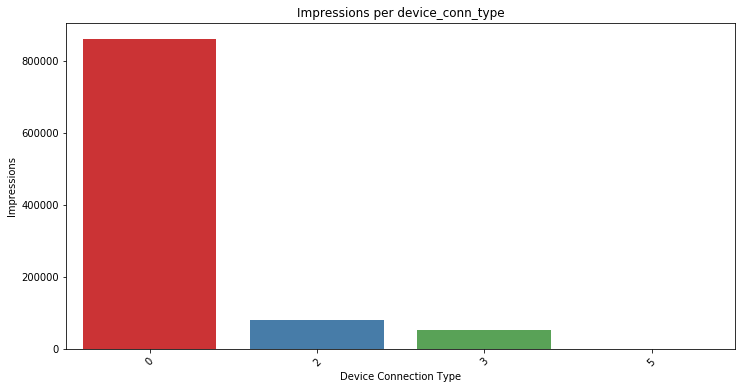

In [39]:
UNIQUE_DEVICE_CONN = raw_data.device_conn_type.nunique()
print(f'Unique device connection type: {UNIQUE_DEVICE_CONN}')
print()

data = raw_data.device_conn_type.value_counts().reset_index()

plt.figure(figsize=(12,6))
chart = sns.barplot(data=data, x='index', y='device_conn_type',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per device_conn_type')
plt.xlabel('Device Connection Type')
plt.ylabel('Impressions')
plt.show()

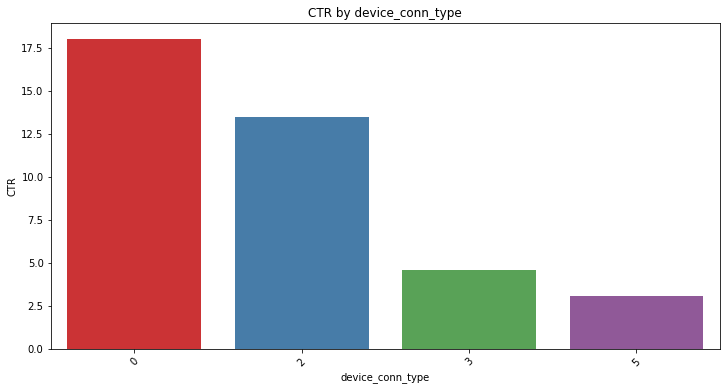

In [40]:
dev_conn_ctr_cor = raw_data[['device_conn_type', 'click']].groupby(['device_conn_type']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
dev_conn_ctr_cor.columns = dev_conn_ctr_cor.columns.get_level_values(1)
dev_conn_ctr_cor = dev_conn_ctr_cor.reset_index()
dev_conn_ctr_cor['CTR'] = dev_conn_ctr_cor['clicks']/dev_conn_ctr_cor['impressions'] * 100

plt.figure(figsize=(12,6))
chart = sns.barplot(data=dev_conn_ctr_cor, 
                    x='device_conn_type',
                    y='CTR',
                    palette='Set1',
                    order=dev_conn_ctr_cor.sort_values(by='CTR', ascending=False).device_conn_type)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by device_conn_type')
plt.show()

### 3.6 Banner(ad) position

Unique banner positions: 7



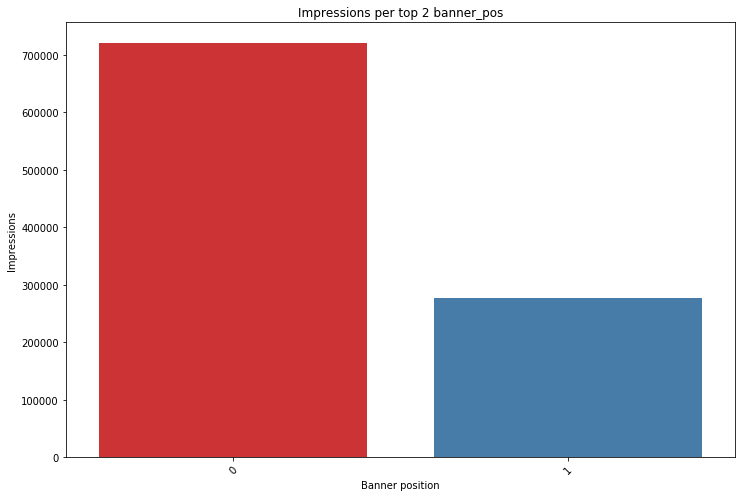

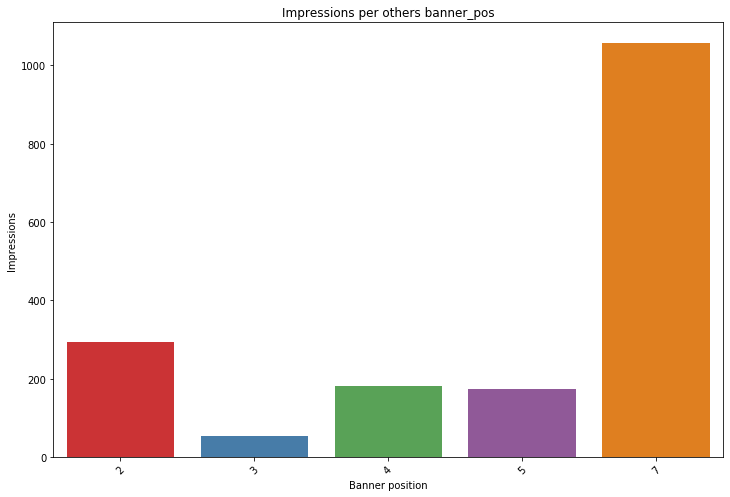

In [74]:
UNIQUE_BANNER_POSTIONS = raw_data.banner_pos.nunique()
print(f'Unique banner positions: {UNIQUE_BANNER_POSTIONS}')
print()

data = raw_data.banner_pos.value_counts().reset_index()

plt.figure(figsize=(12,8))
chart = sns.barplot(data=data[:2], x='index', y='banner_pos',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per top 2 banner_pos')
plt.xlabel('Banner position')
plt.ylabel('Impressions')
plt.show()

plt.figure(figsize=(12,8))
chart = sns.barplot(data=data[2:], x='index', y='banner_pos',palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Impressions per others banner_pos')
plt.xlabel('Banner position')
plt.ylabel('Impressions')
plt.show()

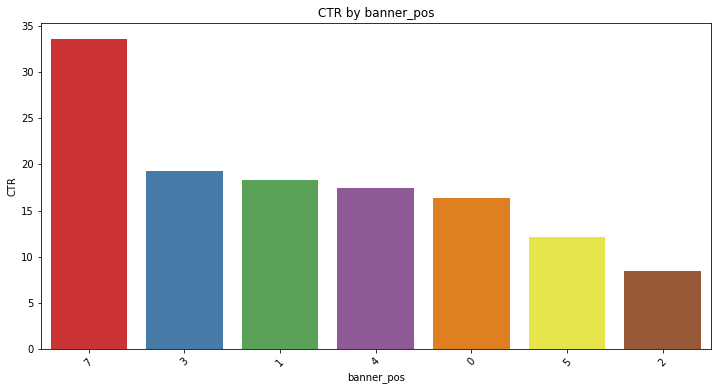

In [42]:
banner_pos_ctr_cor = raw_data[['banner_pos', 'click']].groupby(['banner_pos']).agg({'click': [('clicks', 'sum'), ('impressions', 'count')]})
banner_pos_ctr_cor.columns = banner_pos_ctr_cor.columns.get_level_values(1)
banner_pos_ctr_cor = banner_pos_ctr_cor.reset_index()
banner_pos_ctr_cor['CTR'] = banner_pos_ctr_cor['clicks']/banner_pos_ctr_cor['impressions'] * 100

plt.figure(figsize=(12,6))
chart = sns.barplot(data=banner_pos_ctr_cor, 
                    x='banner_pos',
                    y='CTR',
                    palette='Set1',
                    order=banner_pos_ctr_cor.sort_values(by='CTR', ascending=False).banner_pos)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('CTR by banner_pos')
plt.show()

## 4. Feature enginering

During analize we concluded that hour_of_day and day_of_week will be good features to add alse we can creater user_id using formula: deviceip + devicemodel, if device_id is a99f214a else device_id

In [17]:

raw_data['hour_by_day'] = raw_data.date.apply(lambda d: d.hour)
raw_data['day_by_week_num'] = raw_data.date.apply(lambda d: d.dayofweek)


### 4.1 Choose best attributes

We can see strong corelation beetween C1 and device type
also all of them have correlation to clicks

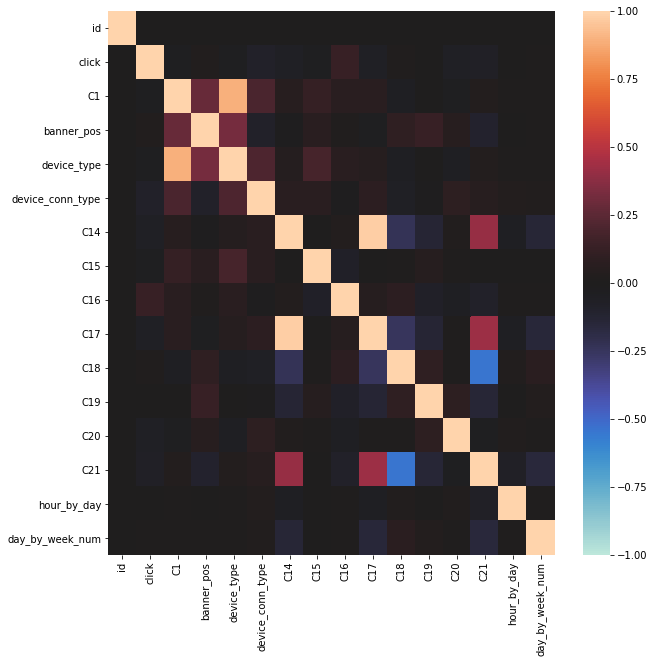

In [19]:
C_ATTRIBUTES = ['C1', 'C14', 'C15','C16','C17','C18','C19','C20', 'click']
TIME_ATTRIBUTES = ['hour_by_day', 'day_by_week_num', 'date']
plt.figure(figsize=(10,10))
sns.heatmap(raw_data.corr(), vmin=-1, vmax=1, center=0)
plt.show()

## 5. Encode categorical data

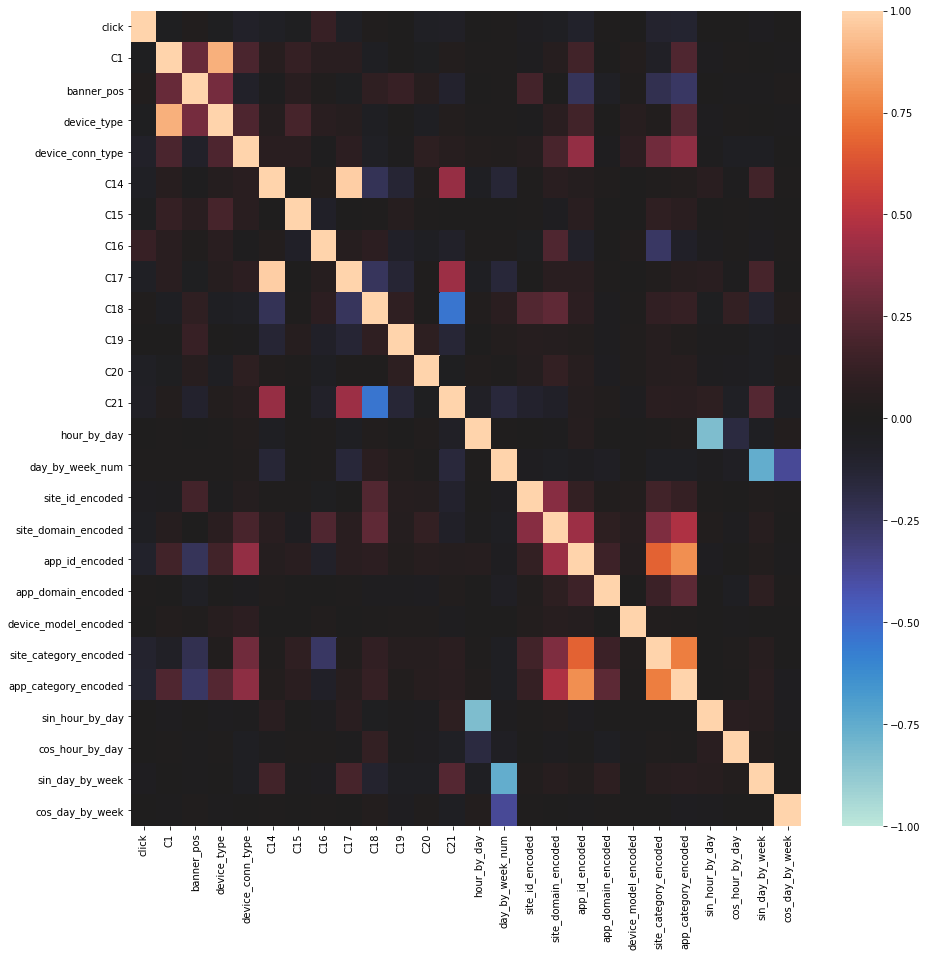

In [18]:
ATTRIBUTES_TO_REMOVE = ['id', 'date', 'device_id', 'device_ip']
HASH_ENCODING = [
    'site_id',
    'site_domain',
    'app_id',
    'app_domain',
    'device_model',
    'site_category',
    'app_category'
]

train_data = raw_data.drop(ATTRIBUTES_TO_REMOVE, axis=1)

for cat in HASH_ENCODING:
    train_data[f'{cat}_encoded'] = train_data[cat].map(lambda x: hash(x))
    train_data = train_data.drop(cat, axis=1)

train_data['sin_hour_by_day'] = np.sin(train_data.hour_by_day*(2.*np.pi/24))
train_data['cos_hour_by_day'] = np.cos(train_data.hour_by_day*(2.*np.pi/24))

train_data['sin_day_by_week'] = np.sin(train_data.day_by_week_num*(2.*np.pi/7))
train_data['cos_day_by_week'] = np.cos(train_data.day_by_week_num*(2.*np.pi/7))

C_ATTRIBUTES = ['site_id_encoded', 'site_domain_encoded', 'site_category_encoded']
TIME_ATTRIBUTES = ['hour_by_day', 'day_by_week_num', 'date']

plt.figure(figsize=(15,15))
sns.heatmap(train_data.corr(), vmin=-1, vmax=1, center=0)
plt.show()

### Circural attributes encoding - hour of day and day of week

In [46]:

train_data['sin_hour_by_day'] = np.sin(train_data.hour_by_day*(2.*np.pi/24))
train_data['cos_hour_by_day'] = np.cos(train_data.hour_by_day*(2.*np.pi/24))

train_data['sin_day_by_week'] = np.sin(train_data.day_by_week_num*(2.*np.pi/7))
train_data['cos_day_by_week'] = np.cos(train_data.day_by_week_num*(2.*np.pi/7))

train_data = train_data.drop(CIRCURAL_ATTRIBUTES, axis=1)

train_data.head()

click    C1  banner_pos   site_id site_domain site_category    app_id  \
0      0  1005           0  85f751fd    c4e18dd6      50e219e0  396df801   
1      0  1005           0  1fbe01fe    f3845767      28905ebd  ecad2386   
2      0  1005           0  030440fe    08ba7db9      76b2941d  ecad2386   
3      0  1005           1  93de26ae    7d05db75      335d28a8  ecad2386   
4      0  1005           0  1fbe01fe    f3845767      28905ebd  ecad2386   

  app_domain app_category device_model  ...   C17  C18  C19     C20  C21  \
0   2347f47a     0f2161f8     36a30aeb  ...  1722    0   35  100084   79   
1   7801e8d9     07d7df22     158e4944  ...  1722    0   35      -1   79   
2   7801e8d9     07d7df22     ef726eae  ...  2161    0   35      -1  157   
3   7801e8d9     07d7df22     272ca818  ...  2161    0   35      -1  157   
4   7801e8d9     07d7df22     8a4875bd  ...  1722    0   35  100084   79   

            user_id  sin_hour_by_day  cos_hour_by_day  sin_day_by_week  \
0  554d9f5f36a30aeb              0.0              1.0         0.781831   
1  8ce11055158e4944              0.0              1.0         0.781831   
2  7407e2ebef726eae              0.0              1.0         0.781831   
3  7768930f272ca818              0.0              1.0         0.781831   
4  435e98ae8a4875bd              0.0              1.0         0.781831   

   cos_day_by_week  
0          0.62349  
1          0.62349  
2          0.62349  
3          0.62349  
4          0.62349  

[5 rows x 25 columns]

### Hash encoding for data with higth cardinality

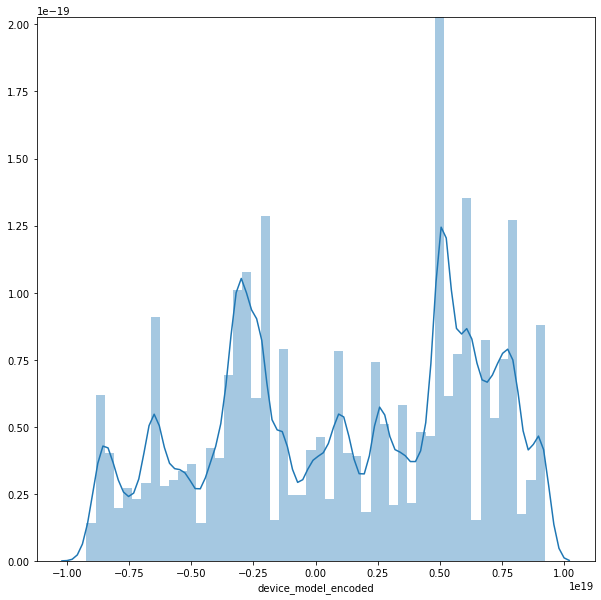

click    C1  banner_pos  device_type  device_conn_type    C14  C15  \
0           0  1005           0            1                 0  15705  320   
1           0  1005           0            1                 0  15707  320   
2           0  1005           0            1                 0  18993  320   
3           0  1005           1            1                 0  18993  320   
4           0  1005           0            1                 0  15708  320   
...       ...   ...         ...          ...               ...    ...  ...   
999995      0  1005           0            1                 0  23918  320   
999996      0  1005           0            1                 2  20632  320   
999997      1  1005           0            1                 0  22254  320   
999998      0  1005           0            1                 0  23866  320   
999999      0  1005           0            1                 0  22257  320   

        C16   C17  C18  ...  app_category_d1327cf5  app_category_dc97ec06  \
0        50  1722    0  ...                      0                      0   
1        50  1722    0  ...                      0                      0   
2        50  2161    0  ...                      0                      0   
3        50  2161    0  ...                      0                      0   
4        50  1722    0  ...                      0                      0   
...     ...   ...  ...  ...                    ...                    ...   
999995   50  2742    0  ...                      0                      0   
999996   50  2374    3  ...                      0                      0   
999997   50  2545    0  ...                      0                      0   
999998   50  2736    0  ...                      0                      0   
999999   50  2545    0  ...                      0                      0   

        app_category_f95efa07  app_category_fc6fa53d      site_id_encoded  \
0                           0                      0 -4563747008910106952   
1                           0                      0  3836419080423886239   
2                           0                      0 -6551636232075857496   
3                           0                      0  2481090042614092073   
4                           0                      0  3836419080423886239   
...                       ...                    ...                  ...   
999995                      0                      0 -4955959400491282121   
999996                      0                      0 -4563747008910106952   
999997                      0                      0  3836419080423886239   
999998                      0                      0 -4563747008910106952   
999999                      0                      0  3836419080423886239   

        site_domain_encoded       app_id_encoded   app_domain_encoded  \
0       7172171229341794876  4746122853175830489 -4685806224855038241   
1      -6797976612330321539 -5040435246998077552  1639538567360019398   
2      -2221329885987662931 -5040435246998077552  1639538567360019398   
3       8709996392415048392 -5040435246998077552  1639538567360019398   
4      -6797976612330321539 -5040435246998077552  1639538567360019398   
...                     ...                  ...                  ...   
999995 -8607798761519251103 -5040435246998077552  1639538567360019398   
999996  7172171229341794876  3024044181231315975 -2592791362867777368   
999997 -6797976612330321539 -5040435246998077552  1639538567360019398   
999998  7172171229341794876 -7498602173823353462  2095147594302515848   
999999 -6797976612330321539 -5040435246998077552  1639538567360019398   

        device_model_encoded      user_id_encoded  
0        4756776650859944365 -6275511183007453953  
1       -3266999023246073735 -4033443473051804302  
2        7896530650103366213  1083392248169385714  
3       -8271241858084962504  1863245755140215532  
4        5073106591618341848  8203336598153471154  
...                      ...    

In [49]:
plt.figure(figsize=(10,10))
sns.distplot(train_data.device_model_encoded)
plt.show()

train_data

### Normalize data 

In [72]:
from sklearn.preprocessing import MinMaxScaler

df_normalized = train_data[:100]
df_normalized = pd.DataFrame(MinMaxScaler().fit_transform(train_data), columns=train_data.columns, index=train_data.index)
df_normalized.describe()

click              C1      banner_pos     device_type  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.169434        0.360690        0.041232        0.203095   
std          0.375135        0.099623        0.072363        0.105715   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.363636        0.000000        0.200000   
50%          0.000000        0.363636        0.000000        0.200000   
75%          0.000000        0.363636        0.142857        0.200000   
max          1.000000        1.000000        1.000000        1.000000   

       device_conn_type             C14             C15             C16  \
count    1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean           0.066212        0.780244        0.220019        0.039919   
std            0.170975        0.209525        0.023811        0.047026   
min            0.000000        0.000000        0.000000        0.000000   
25%            0.000000        0.699045        0.221239        0.029880   
50%            0.000000        0.843798        0.221239        0.029880   
75%            0.000000        0.909202        0.221239        0.029880   
max            1.000000        1.000000        1.000000        1.000000   

                  C17             C18  ...  app_category_d1327cf5  \
count  1000000.000000  1000000.000000  ...         1000000.000000   
mean         0.756374        0.477297  ...               0.003094   
std          0.230465        0.442103  ...               0.055538   
min          0.000000        0.000000  ...               0.000000   
25%          0.662004        0.000000  ...               0.000000   
50%          0.835917        0.666667  ...               0.000000   
75%          0.912665        1.000000  ...               0.000000   
max          1.000000        1.000000  ...               1.000000   

       app_category_dc97ec06  app_category_f95efa07  app_category_fc6fa53d  \
count         1000000.000000         1000000.000000         1000000.000000   
mean                0.001362               0.028079               0.000568   
std                 0.036880               0.165199               0.023826   
min                 0.000000               0.000000               0.000000   
25%                 0.000000               0.000000               0.000000   
50%                 0.000000               0.000000               0.000000   
75%                 0.000000               0.000000               0.000000   
max                 1.000000               1.000000               1.000000   

       site_id_encoded  site_domain_encoded  app_id_encoded  \
count   1000000.000000       1000000.000000  1000000.000000   
mean          0.425513             0.569016        0.339202   
std           0.237141             0.330399        0.231252   
min           0.000000             0.000000        0.000000   
25%           0.251685             0.155688        0.226240   
50%           0.284116             0.680052        0.226240   
75%           0.708036             0.888793        0.364833   
max           1.000000             1.000000        1.000000   

       app_domain_encoded  device_model_encoded  user_id_encoded  
count      1000000.000000        1000000.000000   1000000.000000  
mean             0.506057              0.558568         0.500101  
std              0.177192              0.281637         0.288572  
min              0.000000              0.000000         0.000000  
25%              0.359933              0.331697         0.249855  
50%              0.593316              0.569838         0.500190  
75%              0.593316              0.809389         0.749649  
max              1.000000              1.000000         1.000000  

[8 rows x 71 columns]